Tutorial 8: Fitting
===================

In this example, we'll fit the _Imaging_ data we simulated in the previous exercise. We'll do this using model images
generated via a _Tracer_, and by comparing to the simulated image we'll get diagnostics about the quality of the fit.

In [30]:
%matplotlib inline

import autolens as al
import autolens.plot as aplt

We'll need the path to the chapter in this tutorial to load the dataset from your hard-disk.

In [31]:
from pyprojroot import here

workspace_path = str(here())
print("Workspace Path: ", workspace_path)

Workspace Path:  /home/carlos/autolens_workspace


In [32]:
dataset_path = f"{workspace_path}/howtolens/dataset/chapter_1/"

imaging = al.Imaging.from_fits(
    image_path=f"{dataset_path}/image.fits",
    noise_map_path=f"{dataset_path}/noise_map.fits",
    psf_path=f"{dataset_path}/psf.fits",
    pixel_scales=0.1,
)

The 'imaging' is an _Imaging_ object, which is a 'package' of all components of the dataset, in particular:

    1) The image.
    2) The Point Spread Function (PSF).
    3) Its noise-map.
    
Which are all stored as _Array_ objects.

In [33]:
print("Image:")
print(imaging.image)
print("Noise-Map:")
print(imaging.noise_map)
print("PSF:")
print(imaging.psf)

Image:
[ 0.01253048 -0.01652704 -0.00221622 ... -0.03334412  0.01577613
 -0.02507558]
Noise-Map:
[0.01936754 0.01668062 0.01805397 ... 0.01490591 0.01964486 0.01580342]
PSF:
[2.21033495e-12 1.98968011e-10 6.58891561e-09 8.02694246e-08
 3.59742603e-07 5.93115282e-07 3.59742603e-07 8.02694246e-08
 6.58891561e-09 1.98968011e-10 2.21033495e-12 1.98968011e-10
 1.79105296e-08 5.93115282e-07 7.22562334e-06 3.23829971e-05
 5.33905362e-05 3.23829971e-05 7.22562334e-06 5.93115282e-07
 1.79105296e-08 1.98968011e-10 6.58891561e-09 5.93115282e-07
 1.96412806e-05 2.39279782e-04 1.07237759e-03 1.76805174e-03
 1.07237759e-03 2.39279782e-04 1.96412806e-05 5.93115282e-07
 6.58891561e-09 8.02694246e-08 7.22562334e-06 2.39279782e-04
 2.91502450e-03 1.30642335e-02 2.15392796e-02 1.30642335e-02
 2.91502450e-03 2.39279782e-04 7.22562334e-06 8.02694246e-08
 3.59742603e-07 3.23829971e-05 1.07237759e-03 1.30642335e-02
 5.85498323e-02 9.65323539e-02 5.85498323e-02 1.30642335e-02
 1.07237759e-03 3.23829971e-05 3.

To fit an image, we first specify a _Mask_, which describes the sections of the image that we fit.

Typically, we want to mask regions of the image where the lens and source galaxies are not visible, for example at 
the edges where the signal is entirely background sky and noise.

For the image we simulated, a 3" circular _Mask_ will do the job.

A _Mask_ also takes the 'sub_size' parameter we are used to giving a grid. This does what it does for a _Grid_ - 
defining the (masked) sub-grid used to calculate lensing quantities from a mask.

In [34]:
mask = al.Mask.circular(
    shape_2d=imaging.shape_2d, pixel_scales=imaging.pixel_scales, sub_size=1, radius=3.0
)

print(mask)  # 1 = True, which means the pixel is masked. Edge pixels are indeed masked.
print(mask[48:53, 48:53])  # Whereas central pixels are False and therefore unmasked.

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
[[False False False False False]
 [False False False False False]
 [False False False False False]
 [False False False False False]
 [False False False False False]]


We can use an _Imaging_ _Plotter_ to compare the mask and the image - this is useful if we really want to 'tailor' a 
mask to the lensed source's light (which in this example, we won't).

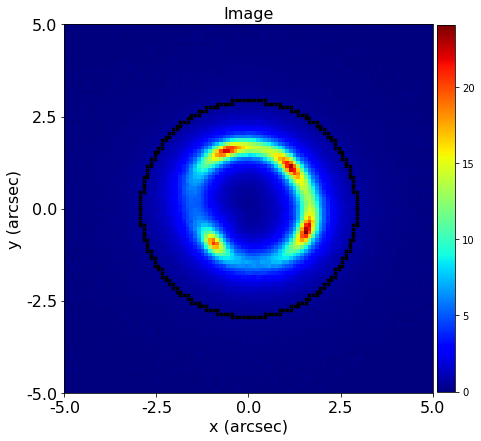

In [35]:
aplt.Imaging.image(imaging=imaging, mask=mask)

The _mask_ automatically 'zooms' our plot around the masked region only - meaning that if our image is very large, we 
focus-in on the lens and source galaxies.

You'll see this is an option for pretty much every _Plotter_ in PyAutoLens, and is something we'll do often throughout 
the tutorials.

To fit the data we create a _MaskedImaging_ object, which is a 'package' of all parts of a data-set we need in order 
to fit it with a lens model:

    1) The imaging-data, including the image, PSF (so that when we compare a tracer's image to the image instrument we 
       can include blurring due to the telescope optics) and noise-map (so our goodness-of-fit measure accounts for 
       noise in the observations).

    2) The mask, so that only the regions of the image with a signal are fitted.

    3) A _Grid_ aligned to the _Imaging_ data's pixels, so the tracer's image is generated on the same (masked) _Grid_ 
       as the image.

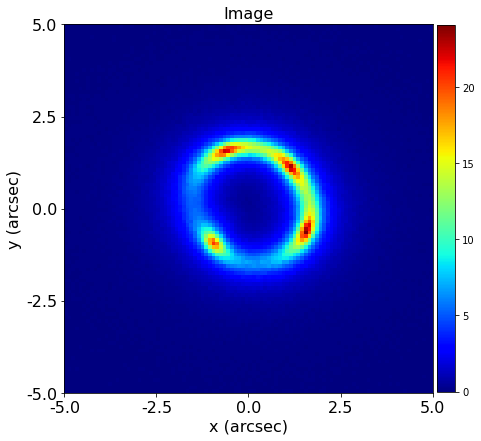

In [36]:
masked_imaging = al.MaskedImaging(imaging=imaging, mask=mask)

aplt.Imaging.image(imaging=masked_imaging.imaging)

By printing its attributes, we can see that it does indeed contain the mask, masked image, masked noise-map, psf and so 
on.

In [37]:
print("Mask")
print(masked_imaging.mask)
print()
print("Masked Image:")
print(masked_imaging.image)
print()
print("Masked Noise-Map:")
print(masked_imaging.noise_map)
print()
print("PSF:")
print(masked_imaging.psf)
print()

Mask
[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]

Masked Image:
[0.41579007 0.42437037 0.53523038 ... 0.37728092 0.33172222 0.35338698]

Masked Noise-Map:
[0.04146445 0.04180791 0.04601559 ... 0.03988654 0.03793513 0.03887531]

PSF:
[2.21033495e-12 1.98968011e-10 6.58891561e-09 8.02694246e-08
 3.59742603e-07 5.93115282e-07 3.59742603e-07 8.02694246e-08
 6.58891561e-09 1.98968011e-10 2.21033495e-12 1.98968011e-10
 1.79105296e-08 5.93115282e-07 7.22562334e-06 3.23829971e-05
 5.33905362e-05 3.23829971e-05 7.22562334e-06 5.93115282e-07
 1.79105296e-08 1.98968011e-10 6.58891561e-09 5.93115282e-07
 1.96412806e-05 2.39279782e-04 1.07237759e-03 1.76805174e-03
 1.07237759e-03 2.39279782e-04 1.96412806e-05 5.93115282e-07
 6.58891561e-09 8.02694246e-08 7.22562334e-06 2.39279782e-0

The masked image and noise-map are again stored in 2D and 1D. 

However, the 1D array now corresponds only to the pixels that were not masked, whereas for the 2D array, all edge 
values are masked and are therefore zeros.

In [38]:
print("The 2D Masked Image and 1D Image of unmasked entries")
print(masked_imaging.image.shape_2d)
print(masked_imaging.image.shape_1d)
print(masked_imaging.image.in_2d)
print(masked_imaging.image.in_1d)
print()
print("The 2D Masked Noise-Map and 1D Noise-Map of unmasked entries")
print(masked_imaging.noise_map.shape_2d)
print(masked_imaging.noise_map.shape_1d)
print(masked_imaging.noise_map.in_2d)
print(masked_imaging.noise_map.in_1d)

The 2D Masked Image and 1D Image of unmasked entries
(100, 100)
2828
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0.41579007 0.42437037 0.53523038 ... 0.37728092 0.33172222 0.35338698]

The 2D Masked Noise-Map and 1D Noise-Map of unmasked entries
(100, 100)
2828
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0.04146445 0.04180791 0.04601559 ... 0.03988654 0.03793513 0.03887531]


The masked data also has a _Grid_, where only coordinates which are not masked are included (the masked 2D values are 
set to [0.0. 0.0]).

In [39]:
# print("Masked Grid")
# print(masked_imaging.grid.in_2d)
# print(masked_imaging.grid.in_1d)

To fit an image, create an image using a _Tracer_. Lets use the same _Tracer_ we simulated the _Imaging_ instrument with 
(thus, our fit is 'perfect').

Its worth noting that below, we use the masked imaging's _Grid_ to setup the _Tracer_. This ensures that our 
image-plane image is the same resolution and alignment as our lens data's masked image.

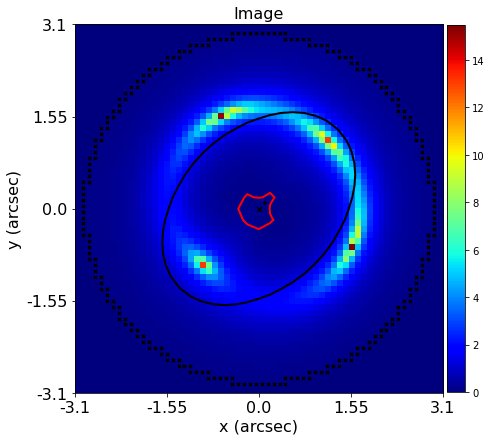

In [40]:
lens_galaxy = al.Galaxy(
    redshift=0.5,
    mass=al.mp.EllipticalIsothermal(
        centre=(0.0, 0.0),
        einstein_radius=1.6,
        elliptical_comps=al.convert.elliptical_comps_from(axis_ratio=0.7, phi=45.0),
    ),
)

source_galaxy = al.Galaxy(
    redshift=1.0,
    light=al.lp.EllipticalSersic(
        centre=(0.1, 0.1),
        elliptical_comps=al.convert.elliptical_comps_from(axis_ratio=0.8, phi=60.0),
        intensity=0.3,
        effective_radius=1.0,
        sersic_index=2.5,
    ),
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

aplt.Tracer.image(tracer=tracer, grid=masked_imaging.grid)

To fit the image, we pass the _MaskedImaging_ and _Tracer_ to a _FitImaging_ object. This performs the following:

    1) Blurs the tracer's image with the lens data's PSF, ensuring the telescope optics are included in the fit. This 
    creates the fit's 'model_image'.

    2) Computes the difference between this model_image and the observed image-data, creating the fit's 'residual_map'.

    3) Divides the residual-map by the noise-map, creating the fit's 'normalized_residual_map'.

    4) Squares every value in the normalized residual-map, creating the fit's 'chi_squared_map'.

    5) Sums up these chi-squared values and converts them to a 'log_likelihood', which quantifies how good the tracer's 
       fit to the data was (higher log_likelihood = better fit).

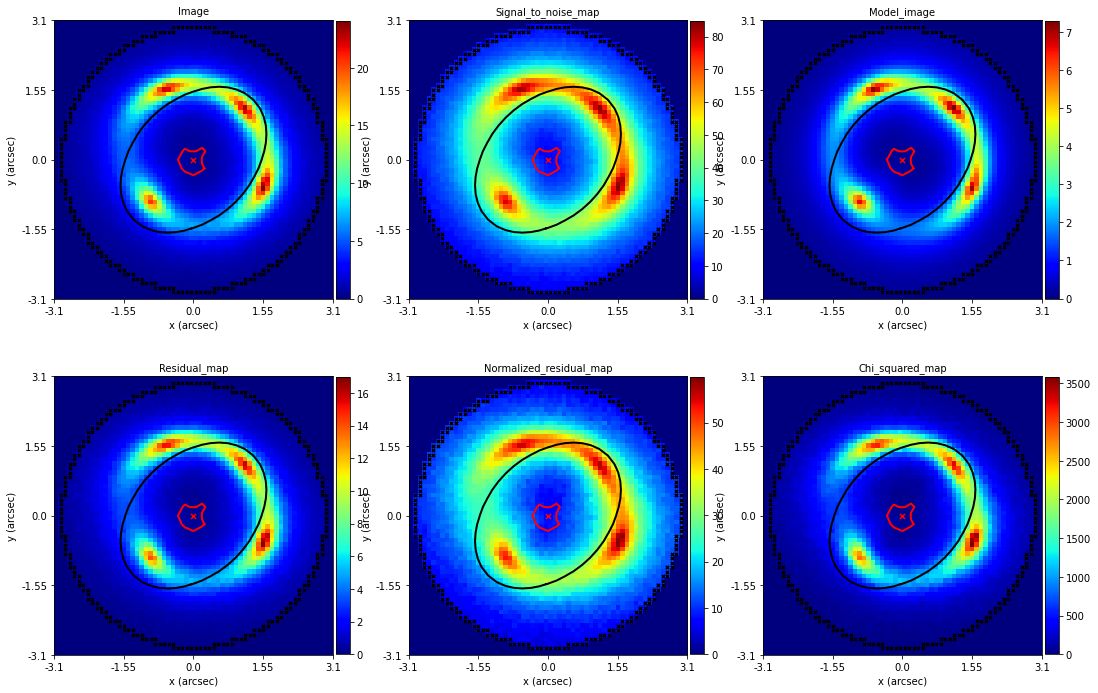

In [41]:
fit = al.FitImaging(masked_imaging=masked_imaging, tracer=tracer)

aplt.FitImaging.subplot_fit_imaging(fit=fit, include=aplt.Include(mask=True))

We can print the fit's attributes. As usual, we can choose whether to return the fits in 2d or 1d, and in 2d if we 
don't specify where we'll get all zeros, as the edges were masked:

In [42]:
print("Model-Image:")
print(fit.model_image.in_2d)
print(fit.model_image.in_1d)
print()
print("Residual Maps:")
print(fit.residual_map.in_2d)
print(fit.residual_map.in_1d)
print()
print("Chi-Squareds Maps:")
print(fit.chi_squared_map.in_2d)
print(fit.chi_squared_map.in_1d)

Model-Image:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0.18687564 0.19362645 0.19939513 ... 0.15443915 0.15219279 0.1491466 ]

Residual Maps:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0.22891443 0.23074392 0.33583526 ... 0.22284177 0.17952943 0.20424038]

Chi-Squareds Maps:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[30.47857273 30.46096359 53.26507759 ... 31.21335068 22.39691239
 27.60167503]


Of course, the central unmasked pixels have non-zero values.

In [43]:
model_image = fit.model_image.in_2d
print(model_image[48:53, 48:53])
print()

residual_map = fit.residual_map.in_2d
print("Residuals Central Pixels:")
print(residual_map[48:53, 48:53])
print()

print("Chi-Squareds Central Pixels:")
chi_squared_map = fit.chi_squared_map.in_2d
print(chi_squared_map[48:53, 48:53])

[[0.13794091 0.14184462 0.15872824 0.17578622 0.18937143]
 [0.15076388 0.14471844 0.14318529 0.14579615 0.155117  ]
 [0.19616924 0.17346949 0.14392813 0.12925937 0.13548306]
 [0.25486933 0.21065487 0.16073471 0.13461695 0.13601101]
 [0.30627448 0.24362318 0.1866397  0.15656165 0.15284435]]

Residuals Central Pixels:
[[0.33685457 0.29662948 0.26312824 0.36011323 0.46309592]
 [0.41883492 0.33340979 0.32833558 0.3608643  0.53565553]
 [0.49523404 0.33382723 0.31928812 0.44651123 0.42788503]
 [0.55155195 0.40873719 0.3930349  0.42982422 0.51411305]
 [0.48093775 0.37913908 0.42614155 0.41693573 0.50919521]]

Chi-Squareds Central Pixels:
[[ 59.22332585  49.02132739  39.80201955  61.18021031  85.50184929]
 [ 78.59453591  57.68378726  56.58809358  64.39666875 108.85311483]
 [ 92.97033124  55.05082709  54.30147249  88.50885647  82.79819392]
 [100.68482433  69.66969659  70.88572072  83.41544979 105.70740675]
 [ 78.211654    59.66544699  76.43156446  77.43255214 102.07334687]]


The fit also gives a log likelihood, which is a single-figure estimate of how good the model image fitted the simulated 
image (in unmasked pixels only!).

In [44]:
print("Likelihood:")
print(fit.log_likelihood)

Likelihood:
-686697.0005836814


We used the same _Tracer_ to create and fit the image, giving an excellent fit. The residual-map and chi-squared-map, 
show no signs of the source-galaxy's light present, indicating a good fit. This solution will translate to one of the 
highest-log_likelihood solutions possible.

Lets change the _Tracer_, so that it's near the correct solution, but slightly off. Below, we slightly offset the lens 
galaxy, by 0.005

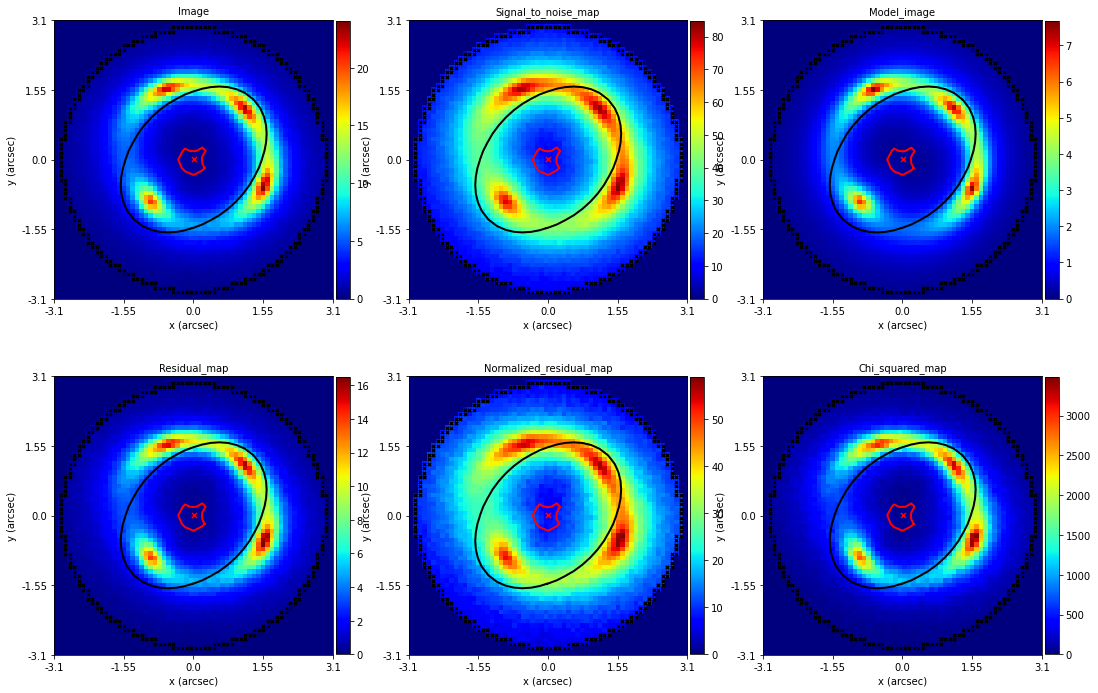

In [45]:
lens_galaxy = al.Galaxy(
    redshift=0.5,
    mass=al.mp.EllipticalIsothermal(
        centre=(0.005, 0.005),
        einstein_radius=1.6,
        elliptical_comps=al.convert.elliptical_comps_from(axis_ratio=0.7, phi=45.0),
    ),
)

source_galaxy = al.Galaxy(
    redshift=1.0,
    light=al.lp.EllipticalSersic(
        centre=(0.1, 0.1),
        elliptical_comps=al.convert.elliptical_comps_from(axis_ratio=0.8, phi=60.0),
        intensity=0.3,
        effective_radius=1.0,
        sersic_index=2.5,
    ),
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

fit = al.FitImaging(masked_imaging=masked_imaging, tracer=tracer)

aplt.FitImaging.subplot_fit_imaging(fit=fit, include=aplt.Include(mask=True))

Residuals now appear at the locations of the source galaxy, increasing the chi-squared values (which determine 
our log_likelihood).

Lets compare the log likelihood to the value we computed above (which was 4372.90):

In [49]:
print("Previous Likelihood:")
print(-686697.0005836814)
print("New Likelihood:")
print(fit.log_likelihood)

Previous Likelihood:
-686697.0005836814
New Likelihood:
-684803.7311839223


It decreases! As expected, this model is a worse fit to the data.

Lets change the _Tracer_, one more time, to a solution nowhere near the correct one.

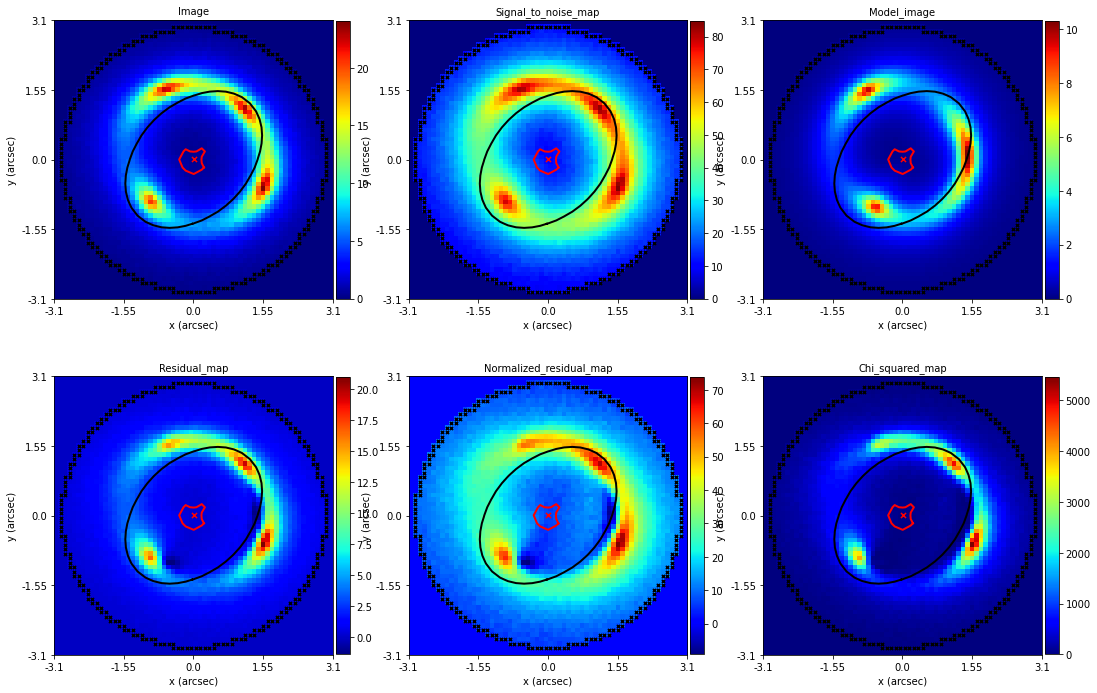

In [50]:
lens_galaxy = al.Galaxy(
    redshift=0.5,
    mass=al.mp.EllipticalIsothermal(
        centre=(0.005, 0.005),
        einstein_radius=1.5,
        elliptical_comps=al.convert.elliptical_comps_from(axis_ratio=0.7, phi=45.0),
    ),
)

source_galaxy = al.Galaxy(
    redshift=1.0,
    light=al.lp.EllipticalSersic(
        centre=(0.2, 0.0),
        elliptical_comps=al.convert.elliptical_comps_from(axis_ratio=0.8, phi=60.0),
        intensity=0.5,
        effective_radius=0.8,
        sersic_index=2.5,
    ),
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

fit = al.FitImaging(masked_imaging=masked_imaging, tracer=tracer)

aplt.FitImaging.subplot_fit_imaging(fit=fit, include=aplt.Include(mask=True))

Clearly, the model provides a terrible fit and this _Tracer_ is not a plausible representation of the _Imaging_ dataset
(of course, we already knew that, given that we simulated it!)

The log likelihood drops dramatically, as expected.

In [52]:
print("Previous Likelihoods:")
print(-686697.0005836814)
print(-684803.7311839223)
print("New Likelihood:")
print(fit.log_likelihood)

Previous Likelihoods:
-686697.0005836814
-684803.7311839223
New Likelihood:
-654218.6942978671


Congratulations, you've fitted your first strong lens with PyAutoLens!